In [1]:
import os
import numpy as np
import pandas as pd
import sys


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# sns.set_style("whitegrid")
sns.set_theme()

In [2]:
# RESULTS_DIR = "./outputs/results-validation"
RESULTS_DIR = "./outputs/"
!ls {RESULTS_DIR}

baseline
experiment1-no-scale-uncertainty-loss
experiment1-uncertainty-loss-with-corrected-lmdb-and-MAE
results-validation


This notebook concerns the evaluation of the model's results.

In [3]:
def color(data, cmap="Blues"):
    return data.style.background_gradient(cmap=cmap, low=0, high=1.0, axis=0)

## Global segmentation results

In [4]:
for model_dir in [f for f in os.listdir(RESULTS_DIR) if "results-validation" not in f]:
    print(model_dir)
    gs_results = pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_global.csv")
    print(gs_results[~gs_results.name.str.contains("polygon")])

    pc_results= pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_by_class.csv")
    print(pc_results[(pc_results.name == "Room segmentation") & (pc_results.class_names == "Wall")])

    hm_results = pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_heatmaps.csv")
    print(hm_results)
    print()

baseline
                name  Overall Acc  Mean Acc  FreqW Acc  Mean IoU
0  Room segmentation     0.825466  0.695622   0.716839  0.572838
2  Icon segmentation     0.975056  0.602284   0.953138  0.549513
                name class_names  Class IoU  Class Acc
2  Room segmentation        Wall      72.16      83.29
                  name  Mean IoU
0  Junction Prediction   0.00123

experiment1-no-scale-uncertainty-loss


FileNotFoundError: [Errno 2] No such file or directory: './outputs//experiment1-no-scale-uncertainty-loss/segmentation_global.csv'

### Class segmentation results

In [5]:
# RESULTS_DIR = RESULTS_DIR
RESULTS_DIR = './outputs/baseline'
gs_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_global.csv")
print(gs_results[~gs_results.name.str.contains("polygon")])

pc_results= pd.read_csv(f"{RESULTS_DIR}/segmentation_by_class.csv")
print(pc_results[~pc_results.name.str.contains("polygon")])

hm_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_heatmaps.csv")
print(hm_results)
print()

                name  Overall Acc  Mean Acc  FreqW Acc  Mean IoU
0  Room segmentation     0.825466  0.695622   0.716839  0.572838
2  Icon segmentation     0.975056  0.602284   0.953138  0.549513
                 name    class_names  Class IoU  Class Acc
0   Room segmentation     Background      87.23      93.70
1   Room segmentation        Outdoor      64.20      77.79
2   Room segmentation           Wall      72.16      83.29
3   Room segmentation        Kitchen      64.88      79.98
4   Room segmentation    Living Room      66.47      82.73
5   Room segmentation        Bedroom      73.98      86.35
6   Room segmentation           Bath      60.43      73.60
7   Room segmentation        Hallway      55.46      71.36
8   Room segmentation        Railing      22.92      27.44
9   Room segmentation        Storage      44.72      53.98
10  Room segmentation         Garage      33.65      47.31
11  Room segmentation    Other rooms      41.32      57.21
24  Icon segmentation          Empty  

In [13]:
print('Rooms')
print(np.mean(pc_results[pc_results.name == 'Room segmentation']['Class Acc']))

print('Icons')
print(np.mean(pc_results[pc_results.name == 'Icon segmentation']['Class Acc']))

Rooms
69.56166666666667
Icons
60.22909090909091


In [47]:
class_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_by_class.csv")
room_mask = class_seg_results.name.isin(["Room segmentation", "Room polygon segmentation"])
room_seg_results, icon_seg_results = class_seg_results[room_mask], class_seg_results[~room_mask]

In [48]:
def get_all_metrics(data):
    ious = data.copy()    
    ious.rename(columns={"Class IoU": "value"}, inplace=True)
    ious.drop(columns=["Class Acc"], inplace=True)
    ious["metric"] = "Class IoU"

    accs = data.copy()    
    accs.rename(columns={"Class Acc": "value"}, inplace=True)
    accs.drop(columns=["Class IoU"], inplace=True)
    accs["metric"] = "Class Acc"

    concat = pd.concat([ious, accs])
    return concat

<AxesSubplot:title={'center':'Room segmentation results discriminated by class'}, xlabel='value', ylabel='class_names'>

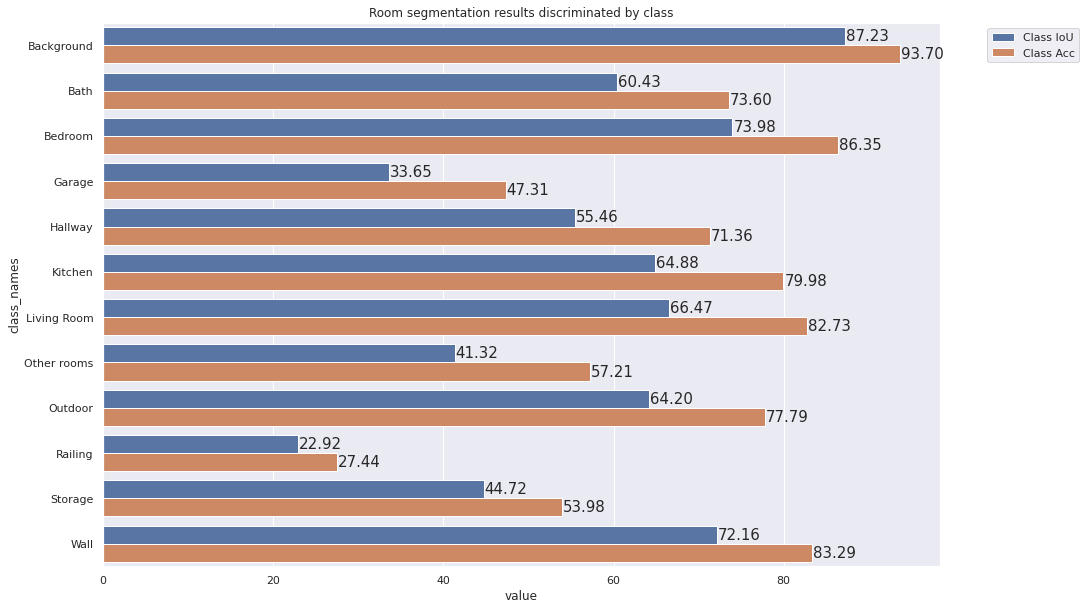

In [49]:
def plot_segmentation_results(data, figsize=(15, 10)):
    data = data.sort_values("class_names")
    plt.figure(figsize=figsize)
    plt.title(f"Room segmentation results discriminated by class")
    plt.ylabel("Class names")
    
    hue_order = ['Class IoU', 'Class Acc']
    splot = sns.barplot(data=data, x="value", y="class_names", hue="metric", hue_order=hue_order, orient="h")

    for p in splot.patches:

        splot.annotate(
            format(p.get_width(), '.2f'), 
            xy=(p.get_width(), p.get_y()+p.get_height()/2),
            ha = 'left',
            va = 'center', 
            size=15, 
            xytext = (1, 0),
            textcoords = 'offset points')
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return splot
        

all_room = get_all_metrics(room_seg_results)
plot_segmentation_results(data=all_room[all_room.name=='Room segmentation'])

### Icon segmentation results

<AxesSubplot:title={'center':'Room segmentation results discriminated by class'}, xlabel='value', ylabel='class_names'>

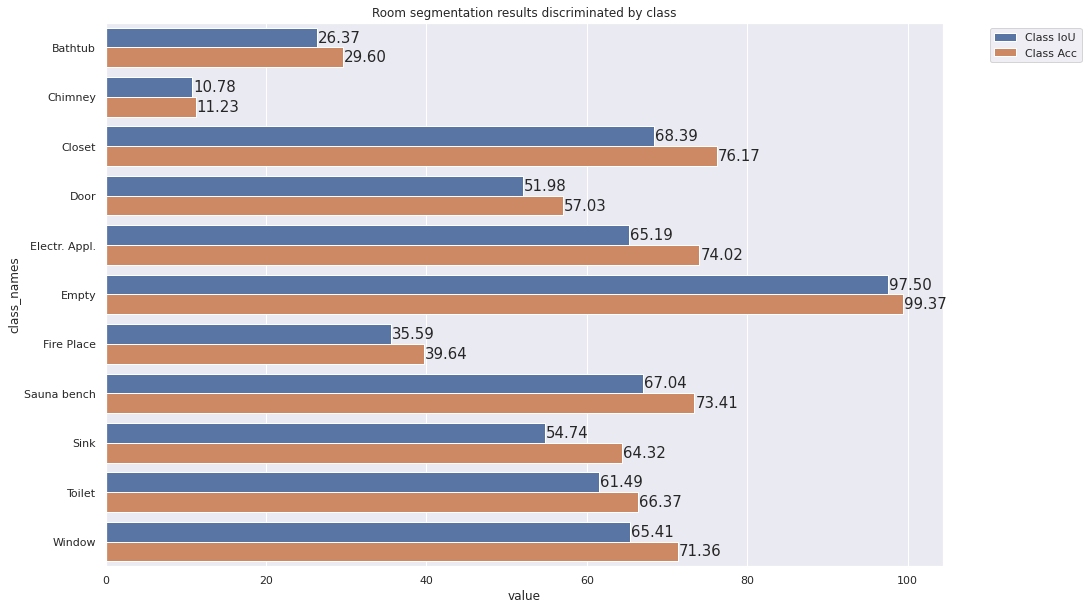

In [50]:
all_icon = get_all_metrics(icon_seg_results)
plot_segmentation_results(data=all_icon[all_icon.name == 'Icon segmentation'])

## Junctions per class

In [51]:
def plot_per_class(
    data: pd.DataFrame,
    by: str,
    x: str,
    y: str,
    n_cols: int=3,
    figsize=(15, 15),
    dpi=150,
    **kwargs
):
    n_plots = data[by].nunique()

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=figsize, dpi=dpi)

    for k, by_category in enumerate(data[by].unique()):
        d = data[(data[by] == by_category)].copy()
        d["F1-score"] = (2*(d["Precision"]/100)*(d["Recall"]/100))/(d["Precision"]/100+d["Recall"]/100)
        d["best"] = d["F1-score"] == d["F1-score"].max()
        d.reset_index(inplace=True, drop=True)

        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x=x, y=y, ax=ax, markers=True, style="class", legend=None, sort=False, **kwargs)
        # ax.set_title(f"({by}={by_category}) {y}-{x} curve")
        plt.plot(d[d.best].Recall, d[d.best].Precision, 'wo', markersize=10)
        plt.plot(d[d.best].Recall, d[d.best].Precision, 'go', markersize=8)
        ax.set_title(f"{by}={by_category}")
        ax.set_xlabel("Recall (%)")
        ax.set_ylabel("Precision (%)")
        ax.set_ylim((15, 105))
        ax.set_xlim((-5, 105))

        for index, row in d.iterrows():
            if row["best"]:
                ax.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f} ($t = {row.threshold/100:.1f}$)")
            else:
                ax.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

    plt.tight_layout()
    plt.savefig(RESULTS_DIR + '/per-class-evaluation-all-classes.pdf')

In [52]:
junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_per_class.csv")
overall_mask = junctions["class"] == "overall"

junctions_overall = junctions[overall_mask]
junctions_by_class = junctions[~overall_mask]

In [53]:
# junctions_overall.loc[100, 'Precision'] = 100.00

junctions_overall["F1-score"] = (2*(junctions_overall["Precision"]/100)*(junctions_overall["Recall"]/100))/(junctions_overall["Precision"]/100+junctions_overall["Recall"]/100)
junctions_overall.reset_index(inplace=True, drop=True)
junctions_overall

/tmp/ipykernel_2036/2864121632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junctions_overall["F1-score"] = (2*(junctions_overall["Precision"]/100)*(junctions_overall["Recall"]/100))/(junctions_overall["Precision"]/100+junctions_overall["Recall"]/100)


,threshold,class,Recall,Precision,F1-score
0,0,overall,77.86,32.79,0.461460
1,10,overall,72.00,47.87,0.575063
2,20,overall,63.99,65.45,0.647118
3,30,overall,55.30,76.10,0.640537
4,40,overall,45.61,82.84,0.588296
5,50,overall,34.07,87.41,0.490296
6,60,overall,22.12,92.86,0.357291
7,70,overall,11.78,95.07,0.209626
8,80,overall,3.64,95.72,0.070133
9,90,overall,0.14,100.00,0.002796


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


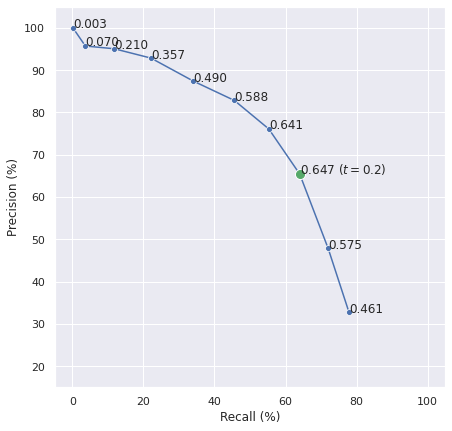

In [54]:
def pr_f1(d: pd.DataFrame, save_path: str = None, xlim=(-5, 105), ylim=(15, 105)):
    d = d.copy()
    d["F1-score"] = (2*(d["Precision"]/100)*(d["Recall"]/100))/(d["Precision"]/100+d["Recall"]/100)
    d["best"] = d["F1-score"] == d["F1-score"].max()
    d.reset_index(inplace=True, drop=True)

    plt.figure(figsize=(7,7))
    sns.lineplot(data=d, x="Recall", y="Precision", markers=True, style="class", legend=None, sort=False)
    plt.plot(d[d.best].Recall, d[d.best].Precision, 'wo', markersize=10)
    plt.plot(d[d.best].Recall, d[d.best].Precision, 'go', markersize=8)

    for index, row in d.iterrows():
        if row["best"]:
            plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f} ($t = {row.threshold/100:.1f}$)")
        else:
            plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")


    plt.xlim((-5, 105))
    plt.ylim((15, 105))
    plt.xlabel("Recall (%)")
    plt.ylabel("Precision (%)")

    if save_path:
        plt.savefig(save_path)

    plt.show()

pr_f1(junctions_overall, RESULTS_DIR + '/precision-recall-overall.pdf')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

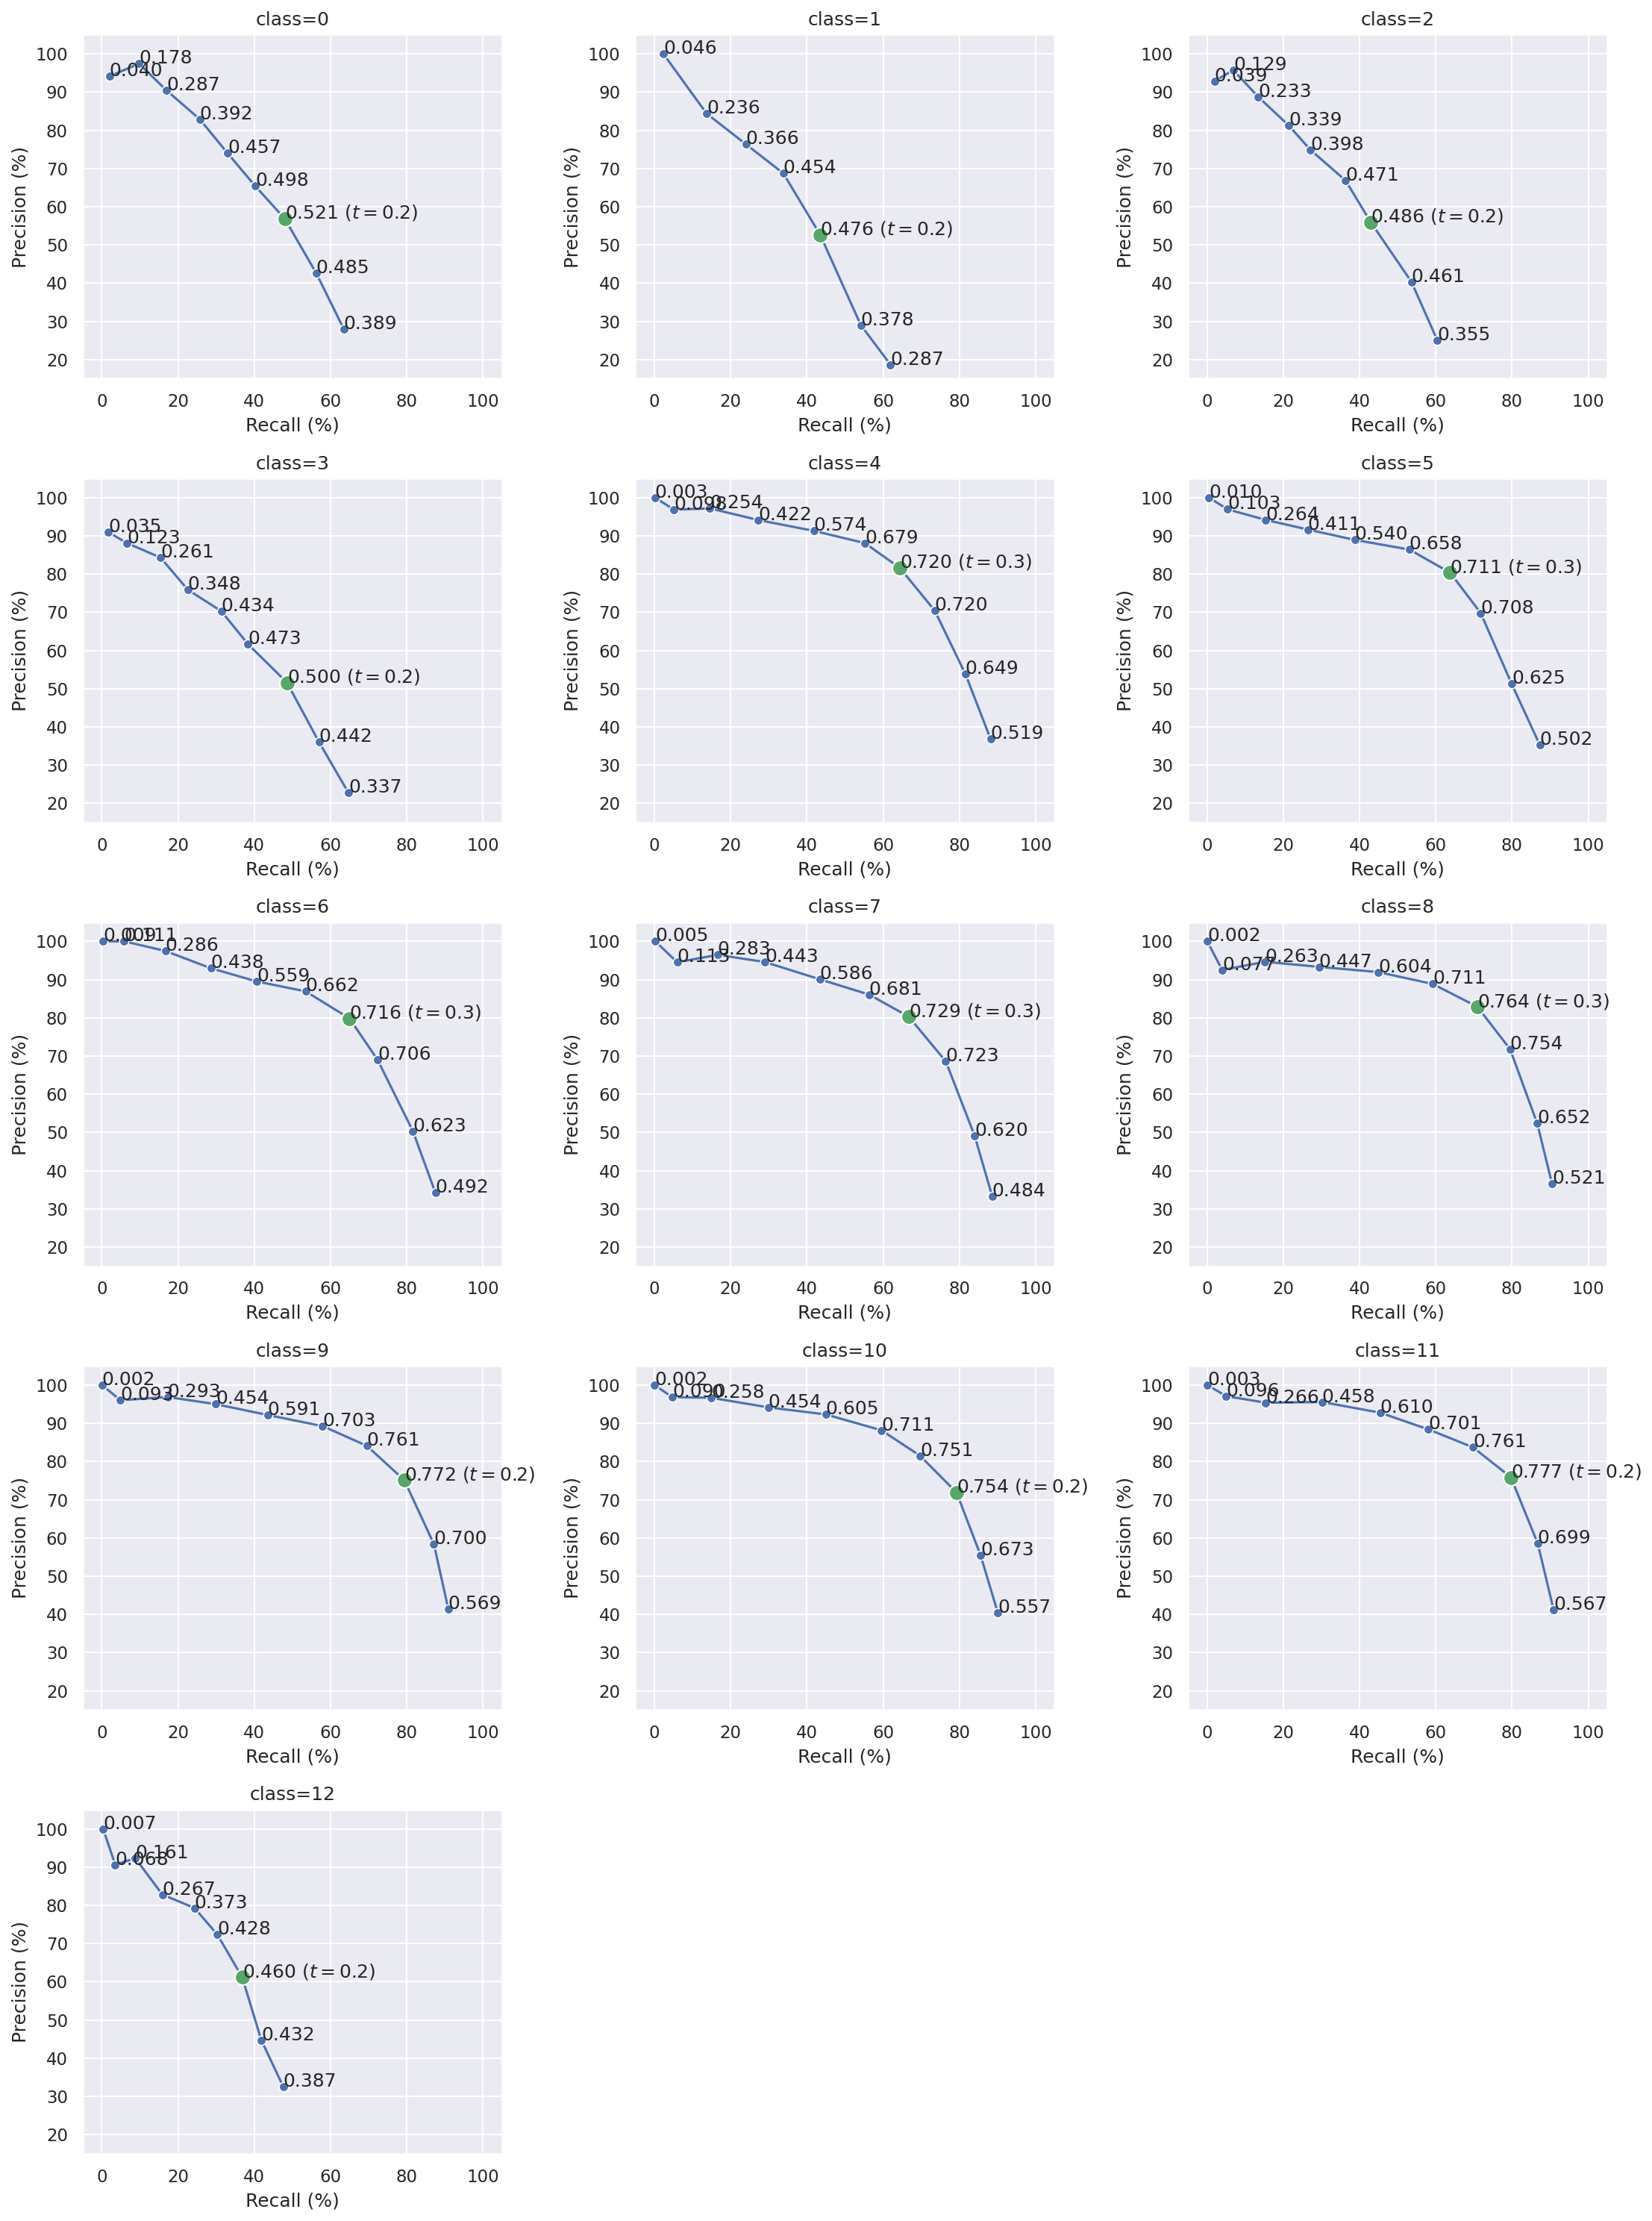

In [55]:
plot_per_class(junctions_by_class, x="Recall", y="Precision", by="class", figsize=(15, 20))

In [56]:
junctions_by_class[junctions_by_class["class"] == "5"]

,threshold,class,Recall,Precision
6,0,5,87.33,35.23
20,10,5,79.91,51.27
34,20,5,71.81,69.77
48,30,5,63.79,80.35
62,40,5,53.10,86.40
76,50,5,38.79,88.93
90,60,5,26.47,91.64
104,70,5,15.34,94.18
118,80,5,5.43,96.92
132,90,5,0.52,100.00


## Wall junctions (no class)

In [57]:
junctions_no_class = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_no_class.csv")
# junctions_no_class.at[10, 'Precision'] = 100.00

junctions_no_class["F1-score"] = (2*(junctions_no_class["Precision"]/100)*(junctions_no_class["Recall"]/100))/(junctions_no_class["Precision"]/100+junctions_no_class["Recall"]/100)
junctions_no_class["class"] = "overall"
print(junctions_no_class)

    threshold  Recall  Precision  F1-score    class
0           0   86.10      50.19  0.634142  overall
1          10   82.29      63.35  0.715885  overall
2          20   75.17      78.35  0.767271  overall
3          30   65.35      86.78  0.745556  overall
4          40   53.83      91.59  0.678076  overall
5          50   40.15      94.50  0.563561  overall
6          60   26.06      96.40  0.410286  overall
7          70   13.83      97.72  0.242307  overall
8          80    4.27      97.41  0.081814  overall
9          90    0.16     100.00  0.003195  overall
10        100    0.00        NaN       NaN  overall


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


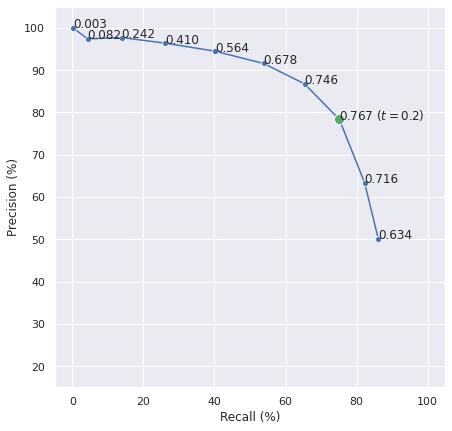

In [58]:
pr_f1(junctions_no_class, RESULTS_DIR + '/precision-recall-no-class.pdf')

## Mixed Junctions

In [59]:
def normalize(data):
    total_gt = data.sum()
    return data/total_gt


def confusion_matrix_by_threshold(data, figsize=(15, 15)):
    for threshold in data.threshold.unique():
        d = data[data.threshold == threshold].copy()
        d.drop(["threshold"], axis=1, inplace=True)

        # Sanity check
        # d = d.apply(normalize, axis=1)
        # d = d.apply(normalize)
        mask = np.zeros_like(d)
        mask[-1, -1] = 1

        plt.figure(figsize=figsize)
        plt.title(f"Threshold={threshold/100:.1f}")
        # sns.heatmap(d, cmap="Blues", vmin=0, vmax=1, annot=True, cbar=False, fmt=".1%", mask=mask, linewidth=.5)
        sns.heatmap(d, cmap="Blues", annot=True, cbar=False, fmt="", mask=mask, linewidth=.5)
        plt.ylabel("Grount Truth")
        plt.xlabel("Predicted")
        # plt.savefig(RESULTS_DIR + f'/confusion-mixed-t={threshold}.pdf')
        plt.show()


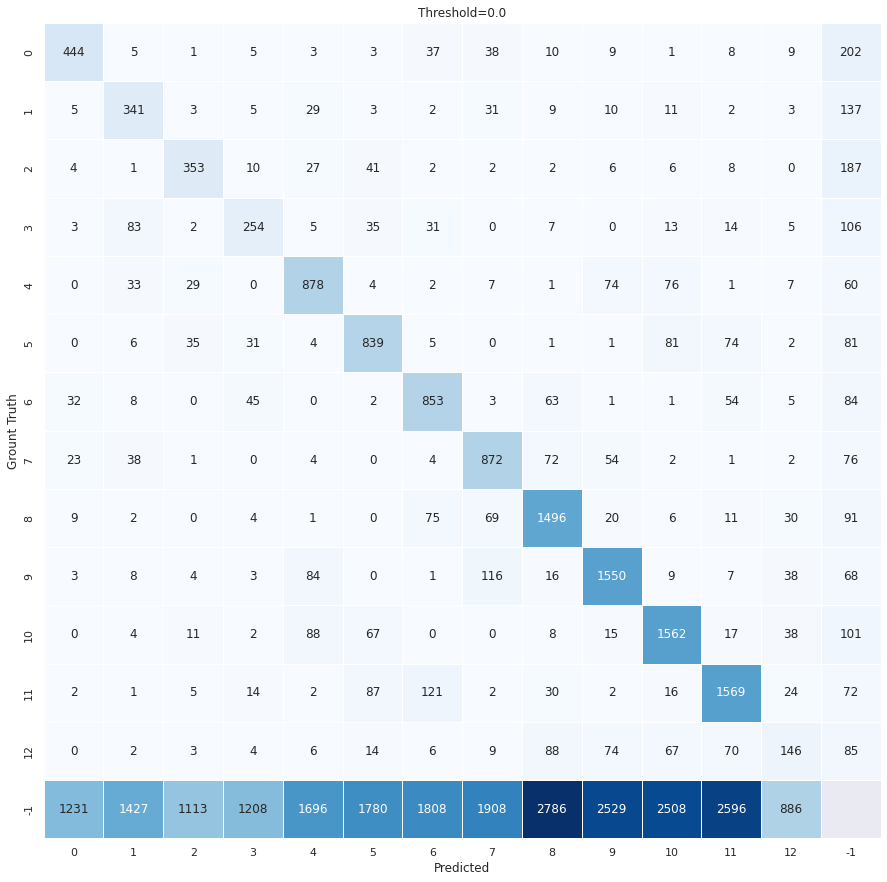

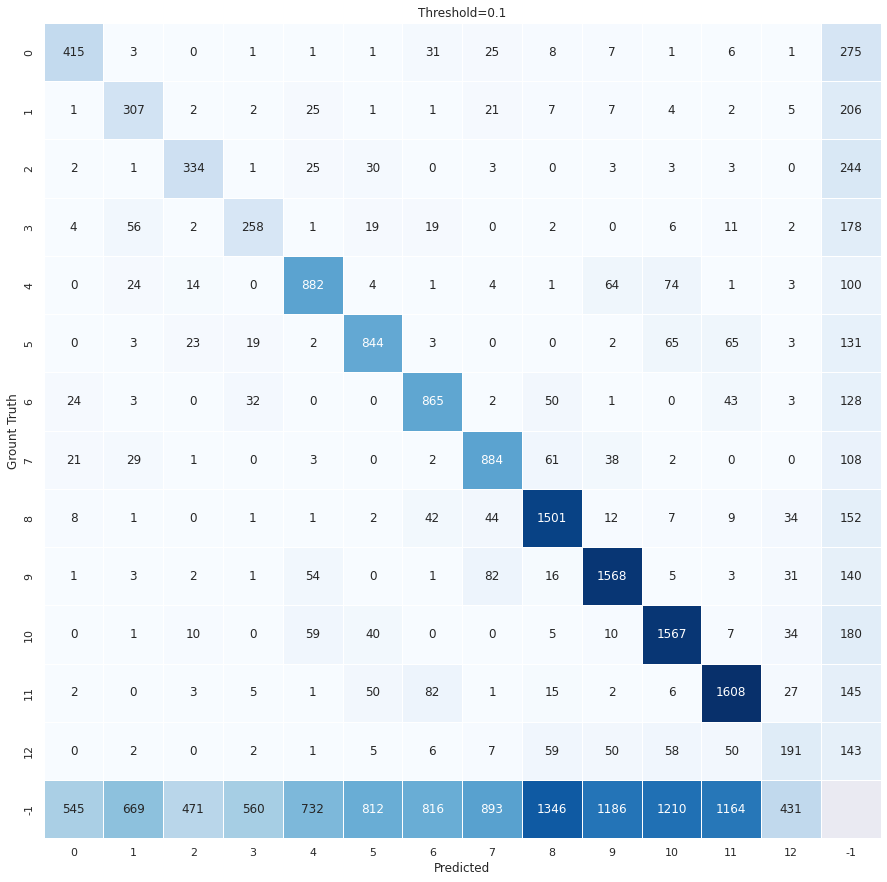

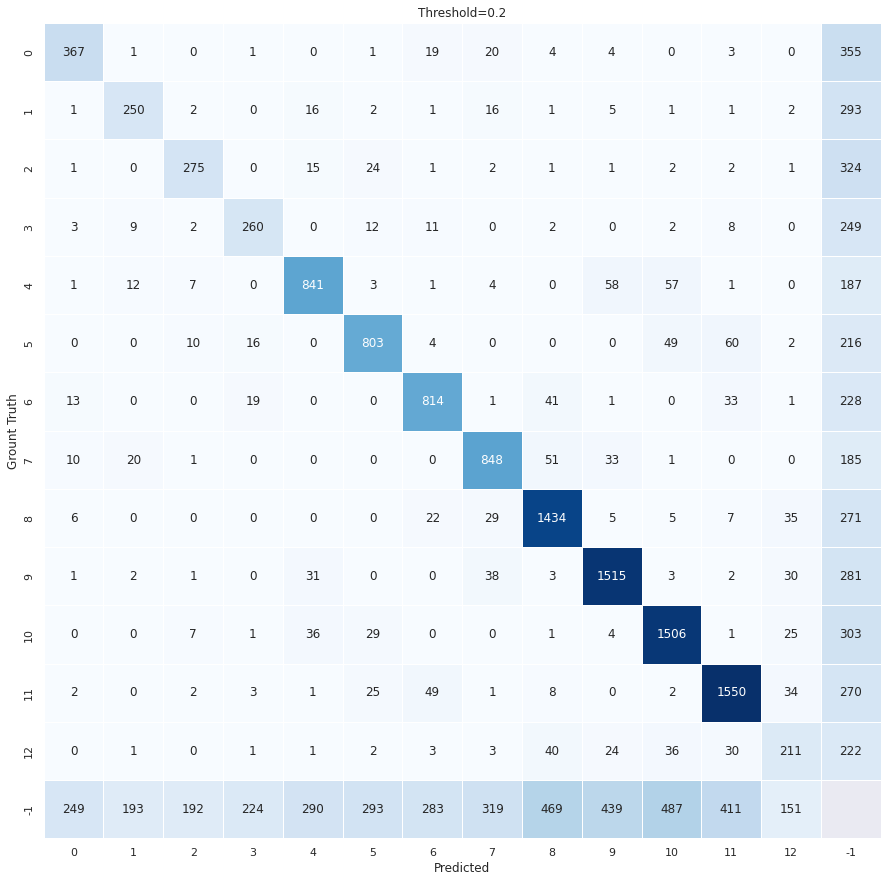

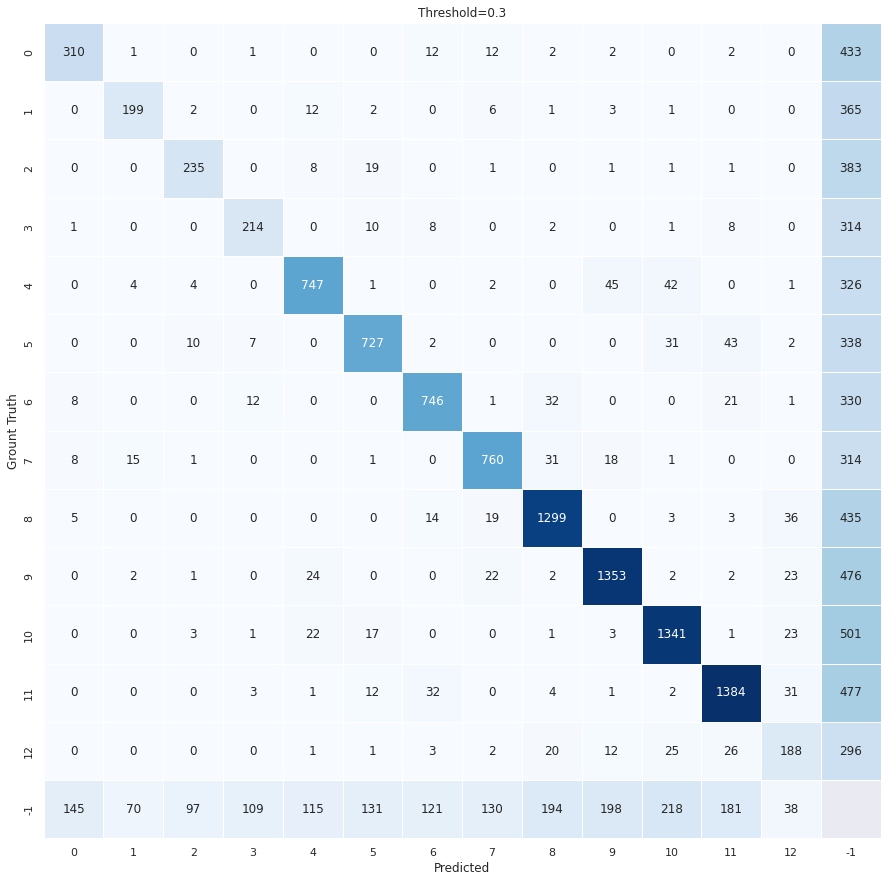

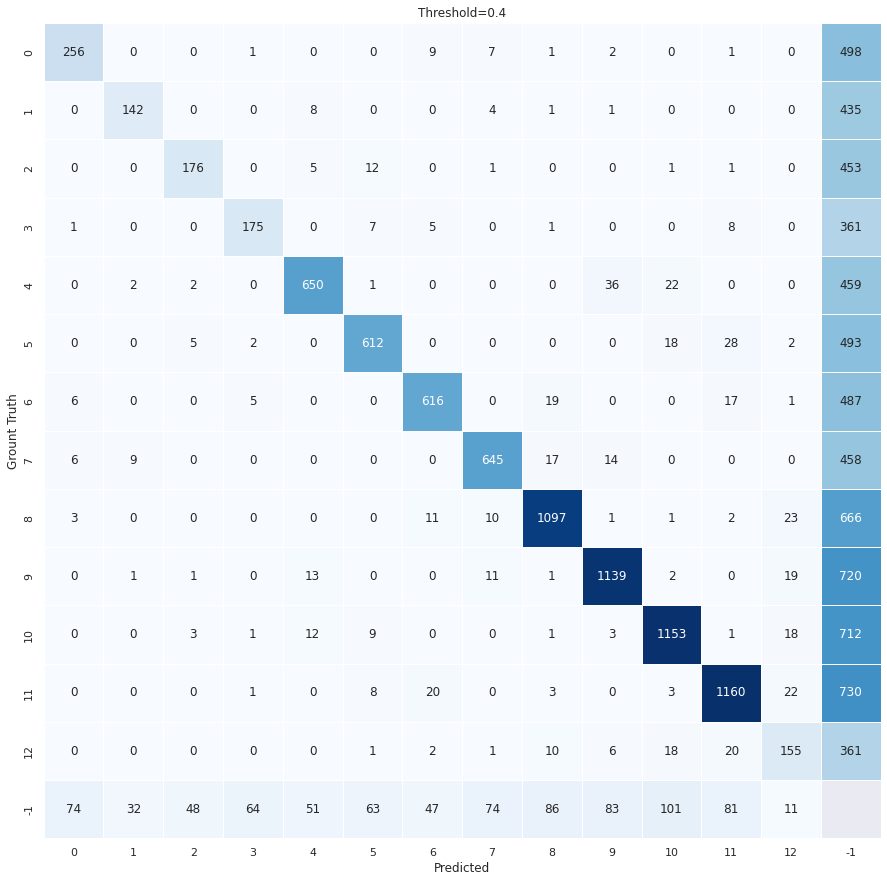

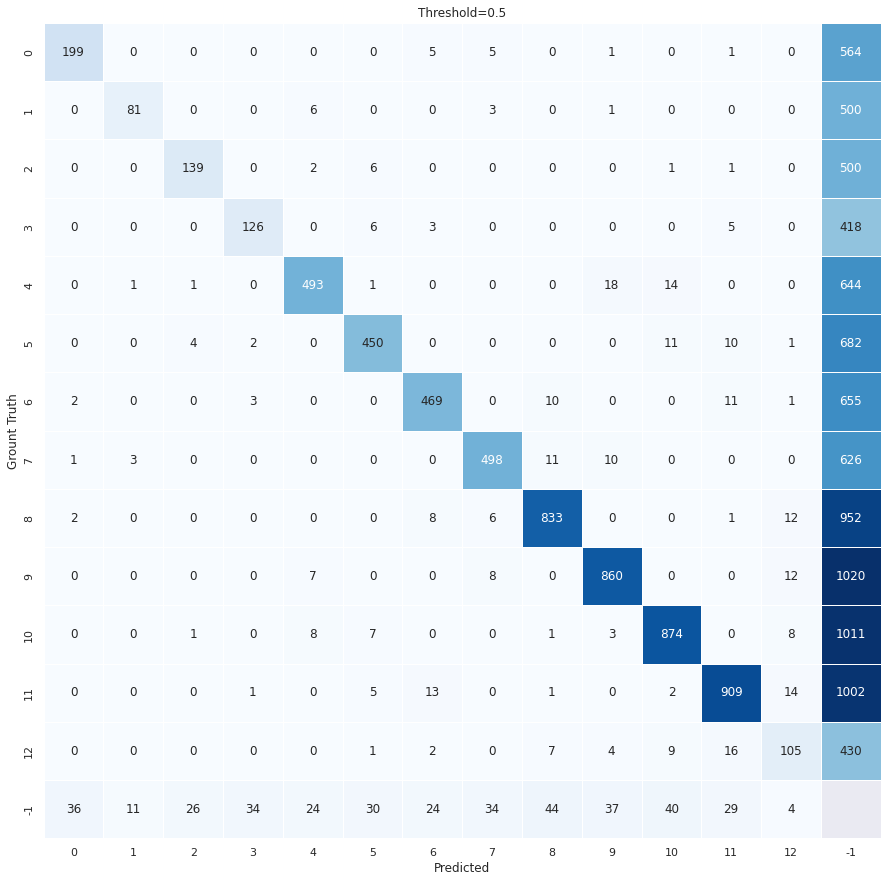

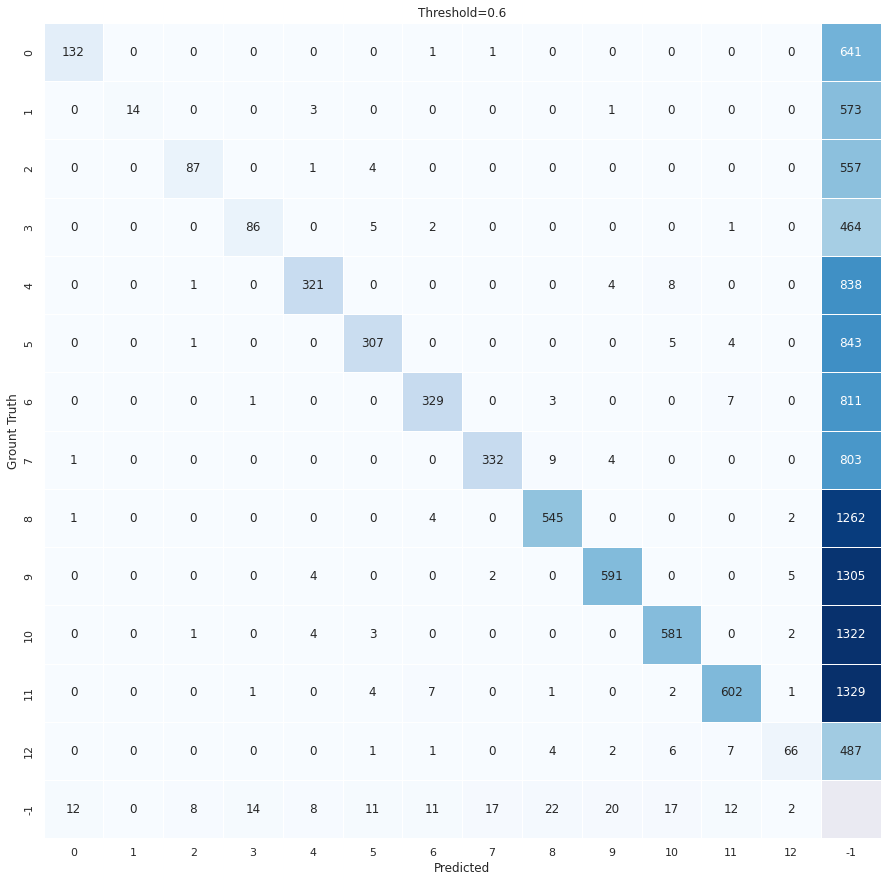

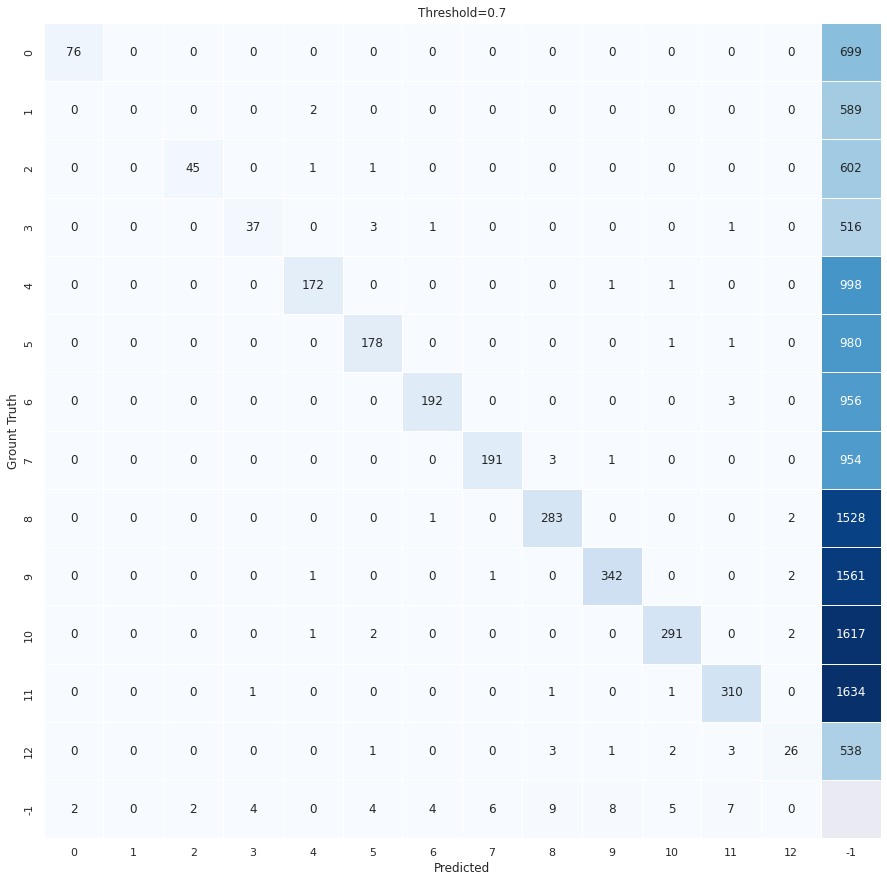

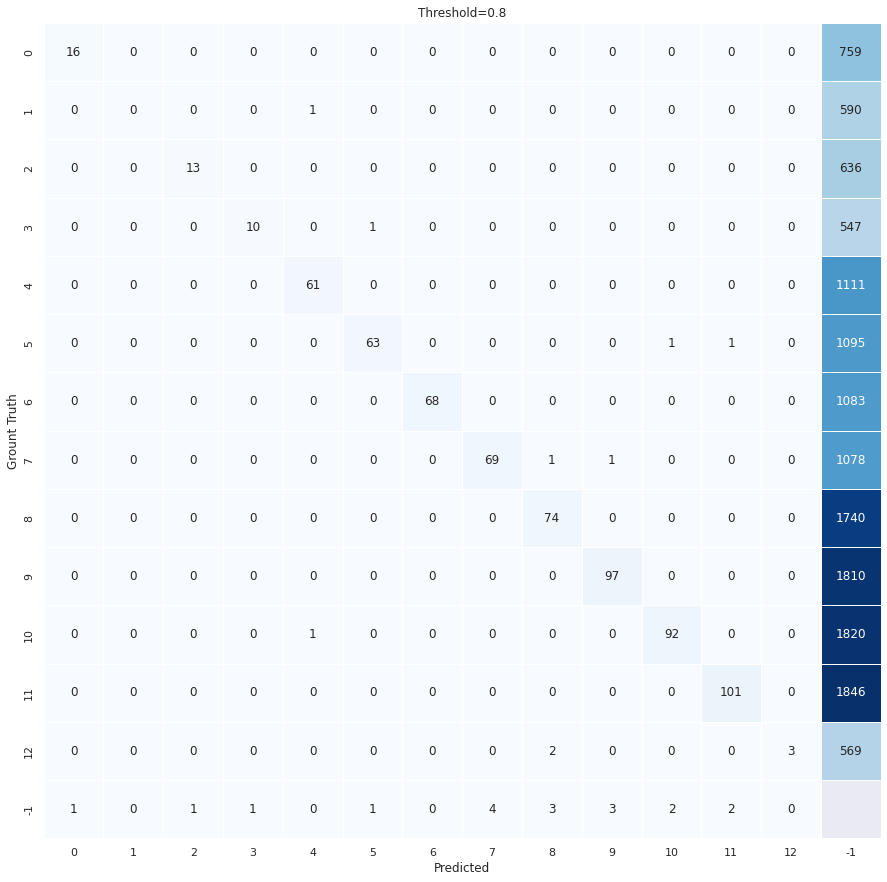

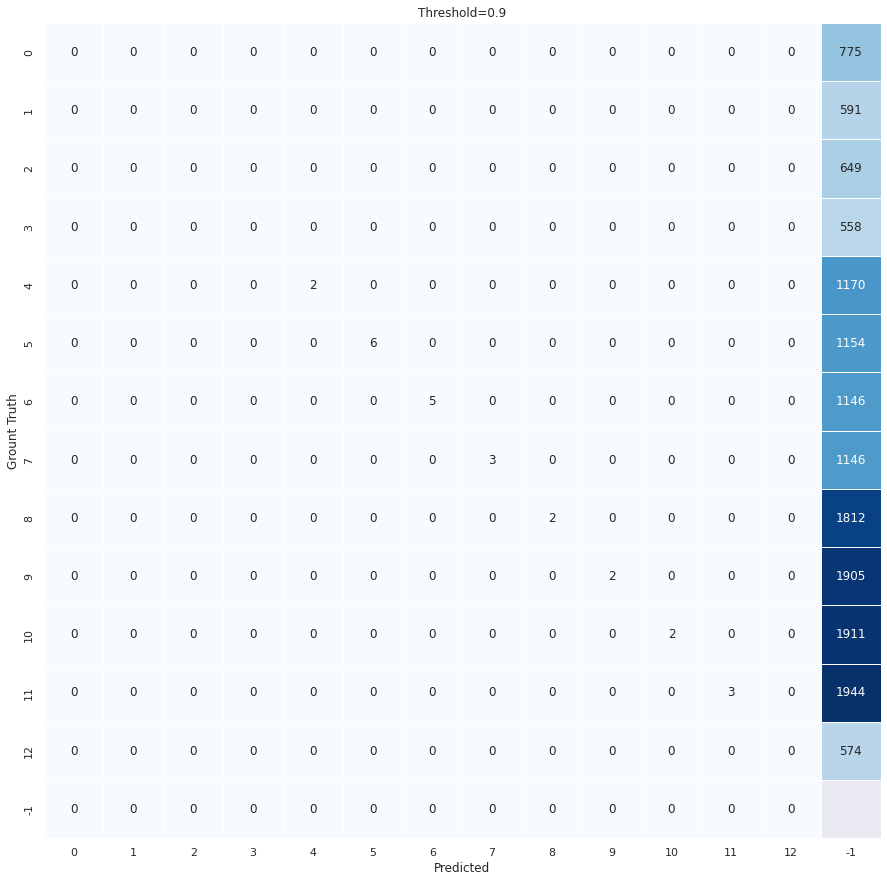

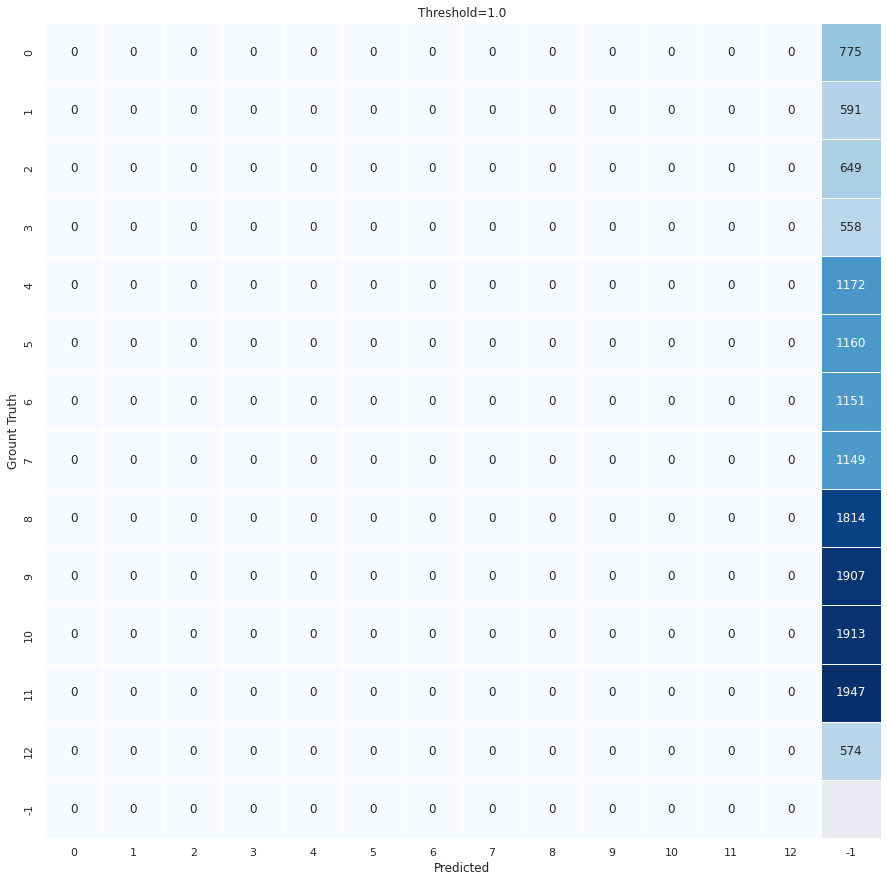

In [60]:
mixed_junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv").set_index("class")
confusion_matrix_by_threshold(mixed_junctions)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


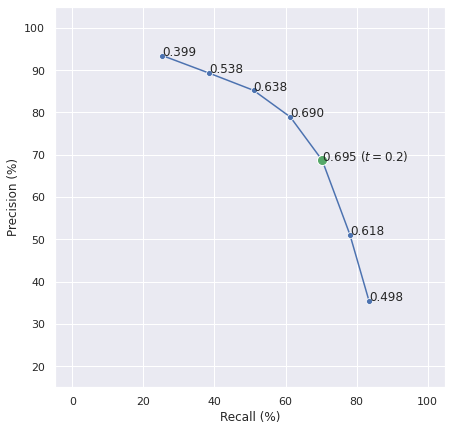

In [61]:
def per_class_weighted_average(data, mixed_junctions):
    res = []
    for t in sorted(data.threshold.unique()):

        d = mixed_junctions[mixed_junctions.threshold == t].copy()
        d = d.sum(axis=1)
        d = d.drop([-1])
        total = d.sum()

        j = data[(data.threshold == t) & (data['class'] != 'overall')]

        d = np.array(list(d))

        j = j.to_numpy()[:, 2:]
        recall = (j[:,0]*d).sum()/total
        precision = (j[:,1]*d).sum()/total

        res.append({'class': 'weighted', 'threshold': t, 'Recall': recall, 'Precision': precision})

    df = pd.DataFrame(res)
    return df

per_class_weighted_avg = per_class_weighted_average(junctions, mixed_junctions)
pr_f1(per_class_weighted_avg, RESULTS_DIR + '/per-class-weighed-average-recall-overall.pdf')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


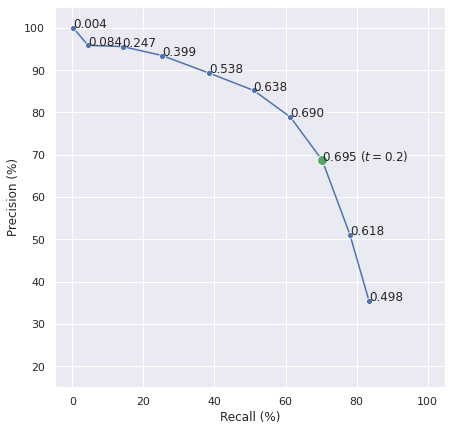

In [62]:
def per_class_weighted_average_nnan(data, mixed_junctions):
    res = []
    for t in sorted(data.threshold.unique()):
        d = mixed_junctions[mixed_junctions.threshold == t].copy()
        d = d.sum(axis=1)
        d = d.drop([-1])

        j = data[(data.threshold == t) & (data['class'] != 'overall')]

        precision = 0
        recall = 0
        total = 0

        for i, row in j.iterrows():
            if pd.isna(row.Recall) or pd.isna(row.Precision):
                continue

            c = int(row['class'])
            recall += row.Recall * d[c]
            precision += row.Precision * d[c]
            total += d[c]

        if total > 0:
            recall /= total
            precision /= total
        else:
            recall = precision = np.nan

        res.append({'class': 'weighted', 'threshold': t, 'Recall': recall, 'Precision': precision})

    df = pd.DataFrame(res)
    return df


per_class_weighted_avg_nnan = per_class_weighted_average_nnan(junctions, mixed_junctions)
pr_f1(per_class_weighted_avg_nnan, RESULTS_DIR + '/per-class-weighed-nnan-average-recall-overall.pdf')

/tmp/ipykernel_2036/1131436036.py:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = num_correct_preds/num_predictions * 100
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


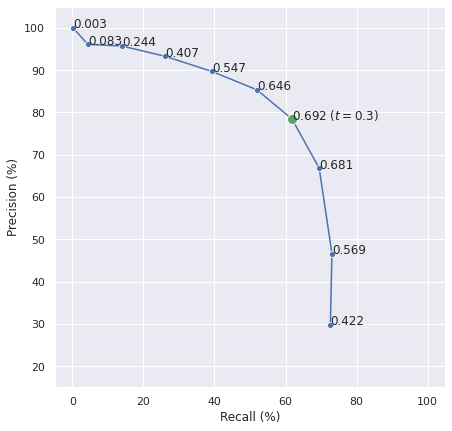

,class,threshold,Recall,Precision,F1-score
0,r2v,0,72.636719,29.763112,0.422246
1,r2v,10,73.072917,46.640349,0.569385
2,r2v,20,69.492188,66.812719,0.681261
3,r2v,30,61.868490,78.414061,0.691655
4,r2v,40,51.927083,85.377863,0.645778
5,r2v,50,39.296875,89.701293,0.546516
6,r2v,60,25.996094,93.316195,0.406640
7,r2v,70,13.951823,95.712372,0.243537
8,r2v,80,4.342448,96.109510,0.083095
9,r2v,90,0.162760,100.000000,0.003250


In [67]:
def pr_by_threshold_r2v(data, figsize=(15, 15)):
    res = []
    for t in data.threshold.unique():
        d = data[data.threshold == t].copy()
        d.drop(["threshold"], axis=1, inplace=True)

        cm = d.to_numpy()
        num_correct_preds = np.sum(np.diag(cm)[:-1])
        num_targets = np.sum(cm[:-1,:])
        num_predictions = np.sum(cm[:,:-1])

        recall = num_correct_preds/num_targets * 100
        precision = num_correct_preds/num_predictions * 100

        res.append({'class': 'r2v', 'threshold': t, 'Recall': recall, 'Precision': precision})
    
    df = pd.DataFrame(res)
    return df

d = pr_by_threshold_r2v(mixed_junctions)
pr_f1(d, RESULTS_DIR + '/overall-r2v.pdf')
d["F1-score"] = (2*(d["Precision"]/100)*(d["Recall"]/100))/(d["Precision"]/100+d["Recall"]/100)
d

/tmp/ipykernel_2036/3718904658.py:14: RuntimeWarning: invalid value encountered in true_divide
  precisions = num_correct_preds/num_predictions_per_class
/tmp/ipykernel_2036/3718904658.py:14: RuntimeWarning: invalid value encountered in true_divide
  precisions = num_correct_preds/num_predictions_per_class
/tmp/ipykernel_2036/3718904658.py:14: RuntimeWarning: invalid value encountered in true_divide
  precisions = num_correct_preds/num_predictions_per_class
/tmp/ipykernel_2036/3718904658.py:14: RuntimeWarning: invalid value encountered in true_divide
  precisions = num_correct_preds/num_predictions_per_class


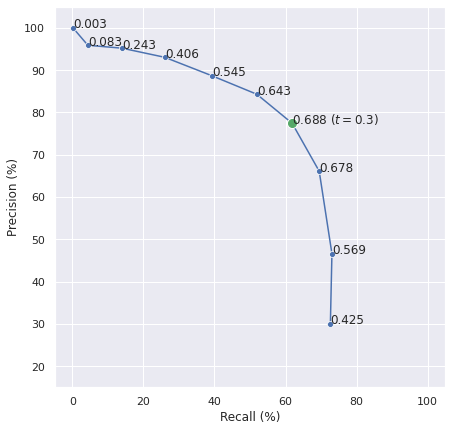

,class,threshold,Recall,Precision
0,r2v,0,72.636719,30.046045
1,r2v,10,73.072917,46.592290
2,r2v,20,69.492188,66.106897
3,r2v,30,61.868490,77.448145
4,r2v,40,51.927083,84.311269
5,r2v,50,39.296875,88.680632
6,r2v,60,25.996094,93.051769
7,r2v,70,13.951823,95.209056
8,r2v,80,4.342448,95.892214
9,r2v,90,0.162760,100.000000


In [64]:
def pr_by_threshold_r2v_avg(data, figsize=(15, 15)):
    res = []
    for t in data.threshold.unique():
        d = data[data.threshold == t].copy()
        d.drop(["threshold"], axis=1, inplace=True)

        cm = d.to_numpy()

        num_correct_preds = np.diag(cm)[:-1]
        num_targets_per_class = np.sum(cm[:-1,:], axis=1)
        num_predictions_per_class = np.sum(cm[:,:-1], axis=0)

        recalls = num_correct_preds/num_targets_per_class
        precisions = num_correct_preds/num_predictions_per_class
        # print(recalls)
        # print(precisions)

        if np.sum(num_predictions_per_class) == 0:
            continue

        recall = np.average(recalls[~np.isnan(recalls)], weights=num_targets_per_class[~np.isnan(recalls)])
        precision = np.average(precisions[~np.isnan(precisions)], weights=num_targets_per_class[~np.isnan(precisions)]) 
        # print(recall)
        # print(precision)
        # print()

        res.append({'class': 'r2v', 'threshold': t, 'Recall': recall*100, 'Precision': precision*100})
    
    df = pd.DataFrame(res)
    return df


d = pr_by_threshold_r2v_avg(mixed_junctions)
pr_f1(d)

d

In [65]:
d = mixed_junctions[mixed_junctions.threshold == 20].copy()
d.drop(["threshold"], axis=1, inplace=True)

cm = d.to_numpy()
# np.sum(cm, axis=1) - np.diag(cm)
num_correct = np.diag(cm)[:-1]
num_targets = np.sum(cm[:-1,:], axis=1)

# percentage of undetected I junctions in relation to all errors
print(np.sum(cm[:4,-1])/(np.sum(np.sum(cm[:4,], axis=1) - np.diag(cm)[:4])))
# percentage of misclassified I junctions in relation to all errors
print((np.sum(cm[:4,:-1]) - np.sum(np.diag(cm)[:4]))/(np.sum(np.sum(cm[:4,], axis=1) - np.diag(cm)[:4])))

# percentage of undetected X junctions in relation to all errors
print(cm[-2,-1]/(np.sum(cm[-2,:]) - cm[-2, -2]))

# precisions
# cm[:,:-1]/np.sum(cm[:,:-1], axis=0)

print(np.sum(np.diag(cm)[:4])/(np.sum(cm[:,:4])))
np.diag(cm)[:-1]/np.sum(cm[:,:-1], axis=0)

0.8592540464461647
0.14074595355383532
0.6115702479338843
0.5318559556786704


array([0.56116208, 0.51229508, 0.5511022 , 0.4952381 , 0.6831844 ,
       0.67252931, 0.67384106, 0.66198283, 0.69781022, 0.72522738,
       0.70013947, 0.73494547, 0.42886179])